In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
import random
import statistics as st #for the mode
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
#repeated measures correlation
import pingouin as pg

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent, mssd
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
if not os.path.exists(path_extracted_data_visual_corr):
    os.makedirs(path_extracted_data_visual_corr)
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [4]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))

130


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#focal birds infot to control for some variables
df_FB = pd.read_csv(os.path.join(config.path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';')
df_FB['early_death'] = df_FB['early_death'].fillna(0).replace(2,1) #2 means not sure
display(df_FB['early_death'].value_counts())
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    222
1.0     10
Name: early_death, dtype: int64

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#HA&KBF&weight
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
print(df_HA.shape)
df_HA = df_HA[df_HA['HenID'].isin(li_selected_hens)]
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
print(df_HA.shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(846, 58)
(534, 58)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,actual_path_img,imageID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,482.0,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp
3,M,16:26,pen3,51grey,normal,100.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,214.0,238.0,40,1.0,51grey3sp,NaN,NaN,"['', '51', 'grey', '3', 'sp']",sp
4,C,08:58,pen12,32orange,normal,25.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,68.0,319.0,2,0.0,32orange12sb,NaN,NaN,"['', '32', 'orange', '12', 'sb']",sb


In [7]:
#dailyMVT var
df_MVT = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT.shape)
df_MVT = df_MVT[df_MVT['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT = df_MVT[df_MVT['level']<=config.max_date_adaptability]
print(df_MVT.shape)
#make sure we have their mvt
df_MVT = df_MVT[~df_MVT['perc_duration_5_Zone'].isnull()]
print(df_MVT.shape)
#add tracking system ID
df_MVT['TrackingSystemID'] = df_MVT['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_MVT['TrackingSystemID'].value_counts())
#df_HA[['HAID','date']].drop_duplicates()
df_MVT.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4repeatibility.csv'), index=False, sep=';')
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42752, 61)
(6232, 61)
(6232, 61)


TrackingSystem 10-12    2495
TrackingSystem 3-5      2170
TrackingSystem 8-9      1567
Name: TrackingSystemID, dtype: int64

,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,TrackingSystemID
3,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-09-30,1,...,0.0,5_Zone,1.0,0.000000,0.000000,100.0,NaN,NaN,NaN,TrackingSystem 10-12
4,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-10-01,2,...,0.0,3_Zone,1.0,33.333333,50.000000,100.0,NaN,NaN,NaN,TrackingSystem 10-12
5,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-10-02,3,...,8.0,5_Zone,0.0,33.333333,66.666667,100.0,NaN,NaN,NaN,TrackingSystem 10-12


In [32]:
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,TrackingSystemID
3,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-09-30,1,...,0.0,5_Zone,1.0,0.000000,0.000000,100.0,NaN,NaN,NaN,TrackingSystem 10-12
4,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-10-01,2,...,0.0,3_Zone,1.0,33.333333,50.000000,100.0,NaN,NaN,NaN,TrackingSystem 10-12
5,hen_131,pen10,EPI,tag_128,19black,4.0,10.06.2020,TRAN,2020-10-02,3,...,8.0,5_Zone,0.0,33.333333,66.666667,100.0,NaN,NaN,NaN,TrackingSystem 10-12


# MLP ~ HA (one obs per hen)

In [8]:
list(df_MVT.columns)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['HenID',
 'PenID',
 'CLASS',
 'TagID',
 'FocalLegringName',
 'R-Pen',
 'InitialStartDate',
 'Treatment',
 'level',
 'DIB',
 'WIB',
 'DOA',
 'WOA',
 'verification_daily_total_duration',
 'dur_values',
 'perc_duration_2_Zone',
 'perc_duration_3_Zone',
 'perc_duration_4_Zone',
 'perc_duration_5_Zone',
 'duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'nbr_stays_1_Zone',
 'nbr_stays_2_Zone',
 'nbr_stays_3_Zone',
 'nbr_stays_4_Zone',
 'nbr_stays_5_Zone',
 'nbr_stays_1_Zone_perh',
 'nbr_stays_2_Zone_perh',
 'nbr_stays_3_Zone_perh',
 'nbr_stays_4_Zone_perh',
 'nbr_stays_5_Zone_perh',
 'ratio_percdur_percstays_2_Zone',
 'ratio_percdur_percstays_3_Zone',
 'ratio_percdur_percstays_4_Zone',
 'ratio_percdur_percstays_5_Zone',
 'latency_2_Zone_h',
 'latency_3_Zone_h',
 'latency_4_Zone_h',
 'latency_5_Zone_h',
 'Total_number_transition',
 'nbr_stays_total',
 'distribution_entropy',
 'Total_number_zone',
 'Max_duration_zones',
 'vertical_travel_dist

### aggregated mvt

In [9]:
li_mvt4MLPs = ['perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'perc_1_Zone_while_WG_open', 'vertical_travel_distance_perh']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#aggregate variable into list and add number of observation available
#df_MLP = df_MVT[df_MVT['WIB']!=1].groupby(['HenID'])[li_mvt4MLPs].agg(lambda x: list(x)).reset_index()
df_MLP = df_MVT.groupby(['HenID'])[li_mvt4MLPs].agg(lambda x: list(x)).reset_index()
df_MLP['nbr_obs'] = df_MLP['perc_duration_5_Zone'].map(lambda x: len(x)) #all varibale has same number of obs except WG
df_MLP['nbr_obs_WG'] = df_MLP['perc_1_Zone_while_WG_open'].map(lambda x: len([i for i in x if not math.isnan(i)]))
#compute mssd and the mean
for var in li_mvt4MLPs:
    df_MLP['mssd_'+var] = df_MLP[var].map(lambda x: mssd(x))
    df_MLP['mean_'+var] = df_MLP[var].map(lambda x: np.nanmean(x))
    df_MLP['sampen_'+var] = df_MLP[var].map(lambda x: sampen(x)) #r=0.2*np.std(x), m=2
    df_MLP['nbr_obs_'+var] = df_MLP[var].map(lambda x: len([i for i in x if not math.isnan(i)]))
print(df_MLP.shape)
df_MLP.head(3)
#df_MLP[[x for x in df_MLP.columns if x.startswith('mssd')|(x.startswith('mean'))]+['severity','Feathers','perc_days_nomvtamngfirst3days']].to_csv(os.path.join(path_extracted_data ,'Adaptability_Stat_MSSD_mixedeffect_R.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2762: RuntimeWarning: divide by zero encountered in log
  return -np.log(A/B)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2762: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A/B)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2762: RuntimeWarning: invalid value encountered in log
  return -np.log(A/B)


(130, 33)


,HenID,perc_duration_5_Zone,perc_duration_4_Zone,perc_duration_3_Zone,perc_duration_2_Zone,perc_1_Zone_while_WG_open,vertical_travel_distance_perh,nbr_obs,nbr_obs_WG,mssd_perc_duration_5_Zone,...,sampen_perc_duration_2_Zone,nbr_obs_perc_duration_2_Zone,mssd_perc_1_Zone_while_WG_open,mean_perc_1_Zone_while_WG_open,sampen_perc_1_Zone_while_WG_open,nbr_obs_perc_1_Zone_while_WG_open,mssd_vertical_travel_distance_perh,mean_vertical_travel_distance_perh,sampen_vertical_travel_distance_perh,nbr_obs_vertical_travel_distance_perh
0,hen_1,"[21.0, 54.0, 98.0, 69.0, 97.0, 100.0, 100.0, 8...","[2.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 4.0, 0.0, ...","[12.0, 17.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0...","[66.0, 29.0, 0.0, 25.0, 0.0, 0.0, 0.0, 7.0, 0....","[nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...","[0.875, 2.0, 0.4444444444444444, 0.88888888888...",49,44,107.541667,...,0.250503,49,53.466345,10.912441,0.129837,44,0.248833,1.047966,0.180176,49
1,hen_10,"[3.0, 91.0, 100.0, 100.0, 78.0, 68.0, 20.0, 30...","[4.0, 9.0, 0.0, 0.0, 6.0, 4.0, 25.0, 13.0, 14....","[53.0, 0.0, 0.0, 0.0, 16.0, 5.0, 17.0, 18.0, 2...","[40.0, 0.0, 0.0, 0.0, 0.0, 23.0, 38.0, 39.0, 3...","[nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, ...","[0.5, 0.2222222222222222, 0.0, 0.0, 0.66666666...",49,42,412.177083,...,1.791759,49,1.371718,0.893140,0.310268,42,0.300711,1.607227,0.157956,49
2,hen_101,"[0.0, 0.0, 0.0, 7.0, 7.0, 17.0, 3.0, 5.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 3.0, 7.0, 1.0, 17.0, 7.0,...","[14.0, 14.0, 17.0, 18.0, 24.0, 19.0, 22.0, 18....","[86.0, 86.0, 83.0, 75.0, 65.0, 57.0, 74.0, 60....","[nan, nan, nan, nan, nan, nan, nan, 0.0, 3.281...","[0.5, 1.1111111111111112, 1.6666666666666667, ...",43,36,110.297619,...,inf,43,38.465020,5.919845,0.493351,36,1.254344,3.877686,0.219997,43


In [11]:
display(df_MVT[['level','DIB']].drop_duplicates().head(5))
# --> only wihtin first three days!! that hte most days with all tracking that we can have continuously
# --> add first 3 days mvt
#%of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DIB'].isin([1,2,3])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
print(df_nnmvt.shape)
df_nnmvt = df_nnmvt[df_nnmvt['nbr_days']==3]
print(df_nnmvt.shape)
df_nnmvt['nbr_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x]))
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['nbr_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['nbr_days_nomvt'].map(lambda x: x>0)
df_nnmvt['nbr_days_4zonevisited'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==4 for i in x]))
#small test
if df_nnmvt[df_nnmvt['nbr_days']!=3].shape[0]>0:
    print('ERROR: you have hens that had no data on one of the first 3 days')
    sys.exit()
display(df_nnmvt.head(3))
#drop the list of values
df_MLP = df_MLP.drop(li_mvt4MLPs, axis=1)
print(df_MLP.shape, df_nnmvt.shape)
df_MLP = pd.merge(df_MLP, df_nnmvt[['HenID','nbr_days_4zonevisited','nbr_days_nomvt']], on=['HenID'], how='inner')
df_MLP.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,DIB
3,2020-09-30,1
4,2020-10-01,2
5,2020-10-02,3
6,2020-10-04,5
7,2020-10-05,6


(130, 4)
(130, 4)


,HenID,PenID,Total_number_zone,nbr_days,nbr_days_nomvt,veri=1,has_nomvt_at_leastoneday,nbr_days_4zonevisited
0,hen_1,pen9,"[4.0, 3.0, 2.0]",3,0,"[False, False, False]",False,1
1,hen_10,pen11,"[4.0, 2.0, 1.0]",3,1,"[False, False, True]",True,1
2,hen_101,pen5,"[2.0, 2.0, 3.0]",3,0,"[False, False, False]",False,0


(130, 27) (130, 8)


,HenID,nbr_obs,nbr_obs_WG,mssd_perc_duration_5_Zone,mean_perc_duration_5_Zone,sampen_perc_duration_5_Zone,nbr_obs_perc_duration_5_Zone,mssd_perc_duration_4_Zone,mean_perc_duration_4_Zone,sampen_perc_duration_4_Zone,...,mssd_perc_1_Zone_while_WG_open,mean_perc_1_Zone_while_WG_open,sampen_perc_1_Zone_while_WG_open,nbr_obs_perc_1_Zone_while_WG_open,mssd_vertical_travel_distance_perh,mean_vertical_travel_distance_perh,sampen_vertical_travel_distance_perh,nbr_obs_vertical_travel_distance_perh,nbr_days_4zonevisited,nbr_days_nomvt
0,hen_1,49,44,107.541667,73.612245,0.274002,49,5.625000,3.938776,0.401392,...,53.466345,10.912441,0.129837,44,0.248833,1.047966,0.180176,49,1,0
1,hen_10,49,42,412.177083,45.183673,1.386294,49,32.208333,8.653061,1.573070,...,1.371718,0.893140,0.310268,42,0.300711,1.607227,0.157956,49,1,1
2,hen_101,43,36,110.297619,16.767442,2.525729,43,11.130952,6.186047,0.629701,...,38.465020,5.919845,0.493351,36,1.254344,3.877686,0.219997,43,0,0


### adding HA5

In [12]:
#add HA results
li_ha = ['severity','Feathers','Person_feather','weight']
HAID = 'HA5'
df_MLPandHA = pd.merge(df_MLP, df_HA[df_HA['HAID']==HAID][['HenID']+li_ha], on=['HenID'], how='inner')
print(df_MLPandHA.shape)
df_MLPandHA.head(3)

(80, 33)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,nbr_obs,nbr_obs_WG,mssd_perc_duration_5_Zone,mean_perc_duration_5_Zone,sampen_perc_duration_5_Zone,nbr_obs_perc_duration_5_Zone,mssd_perc_duration_4_Zone,mean_perc_duration_4_Zone,sampen_perc_duration_4_Zone,...,mssd_vertical_travel_distance_perh,mean_vertical_travel_distance_perh,sampen_vertical_travel_distance_perh,nbr_obs_vertical_travel_distance_perh,nbr_days_4zonevisited,nbr_days_nomvt,severity,Feathers,Person_feather,weight
0,hen_10,49,42,412.177083,45.183673,1.386294,49,32.208333,8.653061,1.573070,...,0.300711,1.607227,0.157956,49,1,1,40,67.000000,Sabine,1713.4
1,hen_101,43,36,110.297619,16.767442,2.525729,43,11.130952,6.186047,0.629701,...,1.254344,3.877686,0.219997,43,0,0,28,72.666667,Sabine,1755.3
2,hen_102,48,41,41.351064,87.312500,0.635040,48,7.531915,5.395833,0.508576,...,0.145991,0.812938,0.035577,48,1,2,50,61.666667,Sabine,2042.7


### adding HA1-5 

In [13]:
df_allha = df_HA.groupby(['HenID']).agg(maxPododermatitis=pd.NamedAgg(column='Pododermatitis', aggfunc=lambda x: max(x)),
                                        maxHasBumblefoot=pd.NamedAgg(column='HasBumblefoot', aggfunc=lambda x: int(max(x))),
                                        maxhas_gap=pd.NamedAgg(column='has_gap', aggfunc=lambda x: max(x)),
                                        nbr_HA=pd.NamedAgg(column='Pododermatitis', aggfunc=lambda x: len(x))).reset_index()
print(df_allha.shape)
df_allha.head(3)

(129, 5)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,maxPododermatitis,maxHasBumblefoot,maxhas_gap,nbr_HA
0,hen_1,50.0,0,0.0,3.0
1,hen_10,125.0,0,0.0,5.0
2,hen_101,50.0,0,1.0,5.0


In [14]:
#add HA results
df_MLPandHA = pd.merge(df_allha, df_MLPandHA, on=['HenID'], how='inner')
print(df_MLPandHA.shape)
df_MLPandHA = df_MLPandHA[df_MLPandHA['nbr_HA']==5] #birds with all 5 HA
print(df_MLPandHA.shape)
df_MLPandHA.head(3)

(80, 37)
(80, 37)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,maxPododermatitis,maxHasBumblefoot,maxhas_gap,nbr_HA,nbr_obs,nbr_obs_WG,mssd_perc_duration_5_Zone,mean_perc_duration_5_Zone,sampen_perc_duration_5_Zone,...,mssd_vertical_travel_distance_perh,mean_vertical_travel_distance_perh,sampen_vertical_travel_distance_perh,nbr_obs_vertical_travel_distance_perh,nbr_days_4zonevisited,nbr_days_nomvt,severity,Feathers,Person_feather,weight
0,hen_10,125.0,0,0.0,5.0,49,42,412.177083,45.183673,1.386294,...,0.300711,1.607227,0.157956,49,1,1,40,67.000000,Sabine,1713.4
1,hen_101,50.0,0,1.0,5.0,43,36,110.297619,16.767442,2.525729,...,1.254344,3.877686,0.219997,43,0,0,28,72.666667,Sabine,1755.3
2,hen_102,110.0,0,1.0,5.0,48,41,41.351064,87.312500,0.635040,...,0.145991,0.812938,0.035577,48,1,2,50,61.666667,Sabine,2042.7


### adding variable to control

In [15]:
# add variable to control for penID, treatment, initial weight, Rearing pen, class
df_FB.rename(columns={'R-Pen':'RPen','29-09 weight':'InitWeight'}, inplace=True)
li_initvar = ['HenID','RPen','CLASS','PenID','Treatment','InitWeight','early_death']
df_MLPandHAandCV = pd.merge(df_MLPandHA, df_FB[li_initvar], 
                            on=['HenID'], how='inner')
print(df_MLPandHA.shape, df_FB.shape, df_MLPandHAandCV.shape)
df_MLPandHAandCV.head(3)

(80, 37) (232, 14) (80, 43)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,maxPododermatitis,maxHasBumblefoot,maxhas_gap,nbr_HA,nbr_obs,nbr_obs_WG,mssd_perc_duration_5_Zone,mean_perc_duration_5_Zone,sampen_perc_duration_5_Zone,...,severity,Feathers,Person_feather,weight,RPen,CLASS,PenID,Treatment,InitWeight,early_death
0,hen_10,125.0,0,0.0,5.0,49,42,412.177083,45.183673,1.386294,...,40,67.000000,Sabine,1713.4,1.0,LEXP,pen11,OFH,1070.0,0.0
1,hen_101,50.0,0,1.0,5.0,43,36,110.297619,16.767442,2.525729,...,28,72.666667,Sabine,1755.3,3.0,MEXP,pen5,OFH,1082.0,0.0
2,hen_102,110.0,0,1.0,5.0,48,41,41.351064,87.312500,0.635040,...,50,61.666667,Sabine,2042.7,3.0,MEXP,pen3,OFH,1158.0,0.0


# Process and save

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


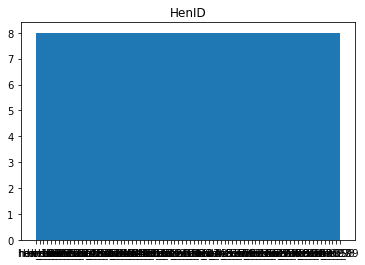

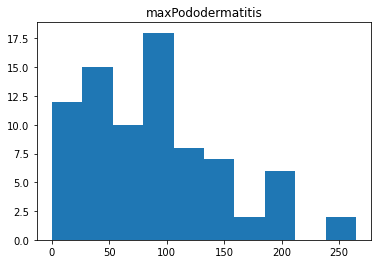

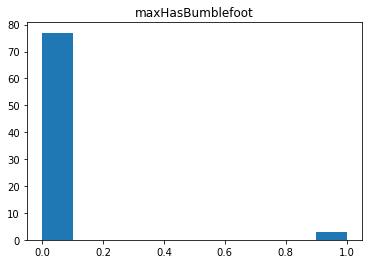

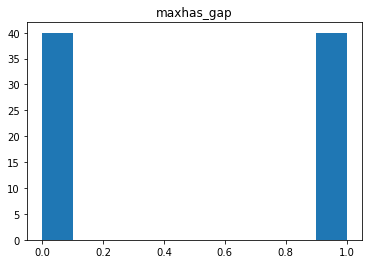

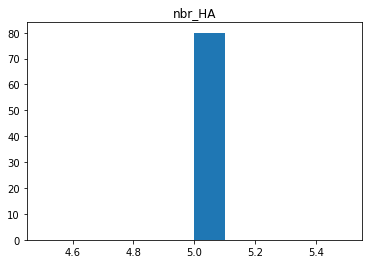

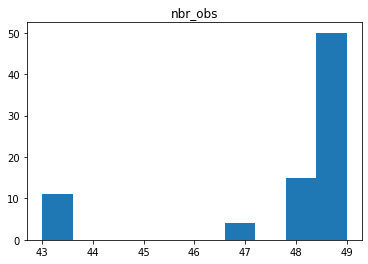

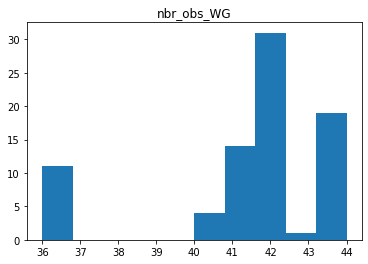

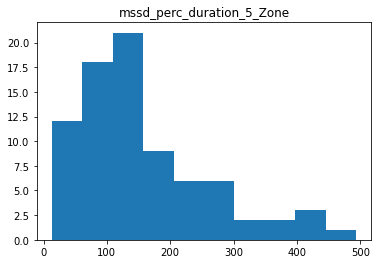

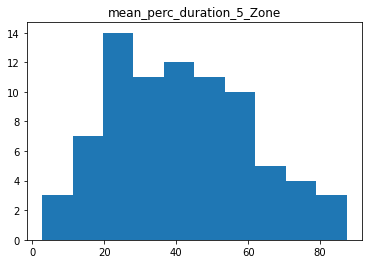

sampen_perc_duration_5_Zone


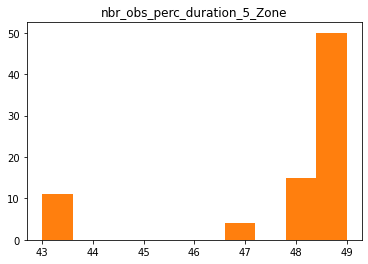

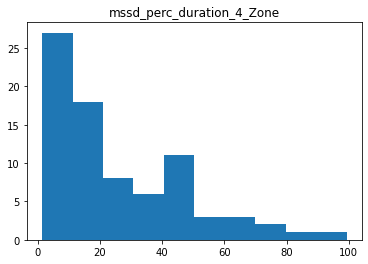

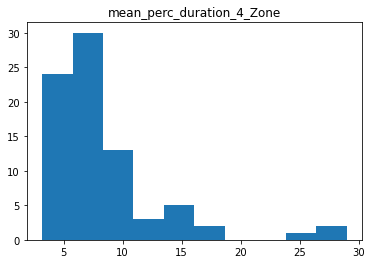

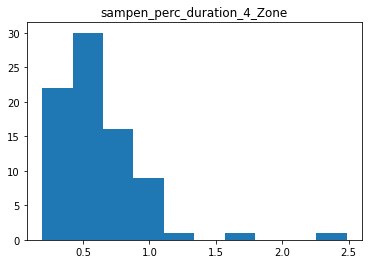

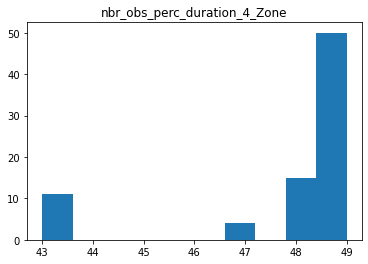

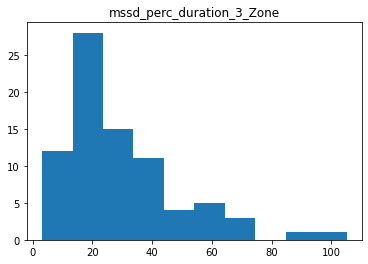

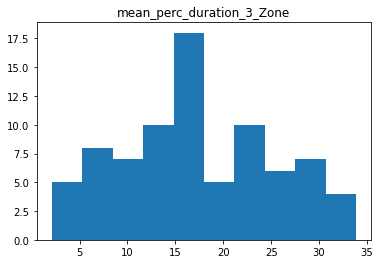

sampen_perc_duration_3_Zone


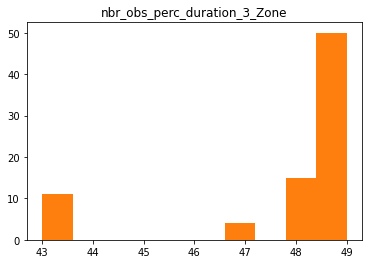

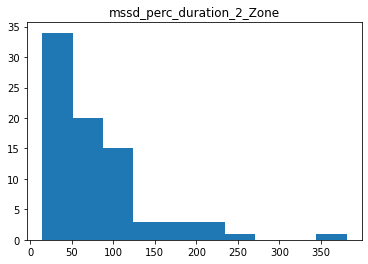

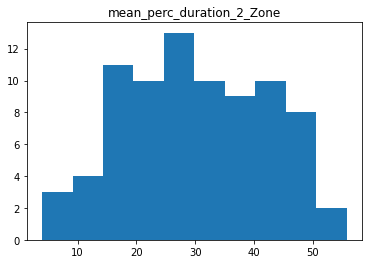

sampen_perc_duration_2_Zone


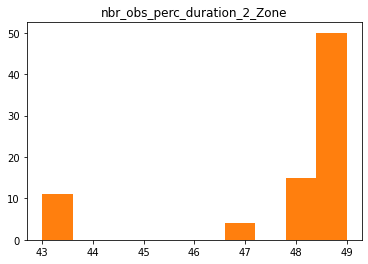

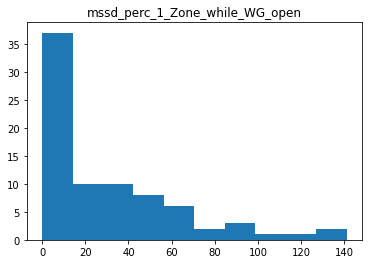

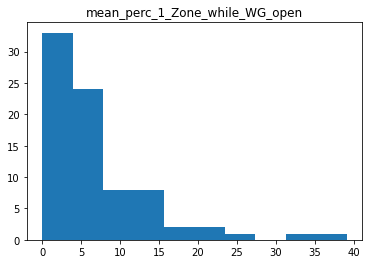

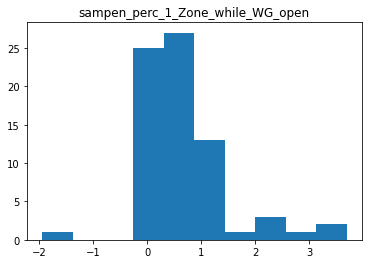

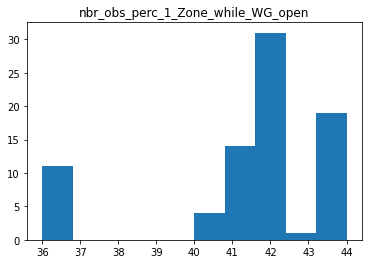

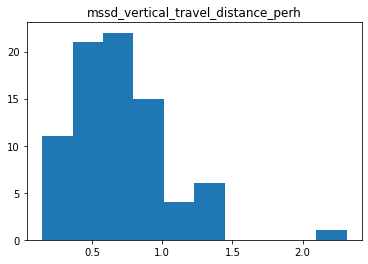

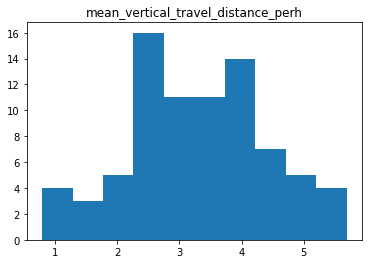

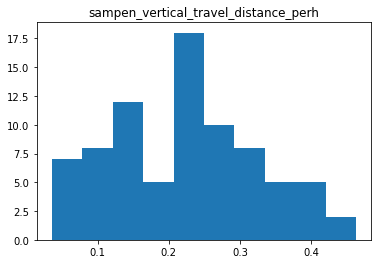

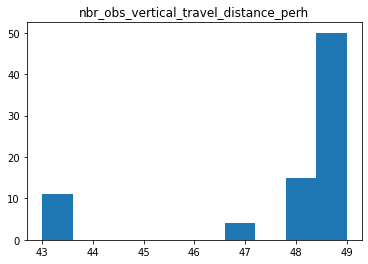

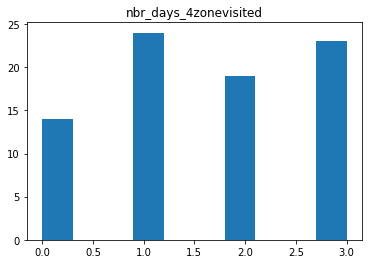

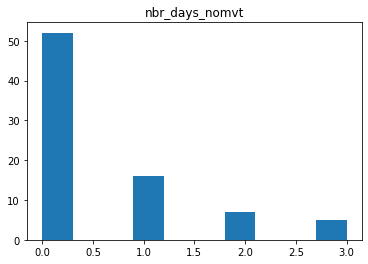

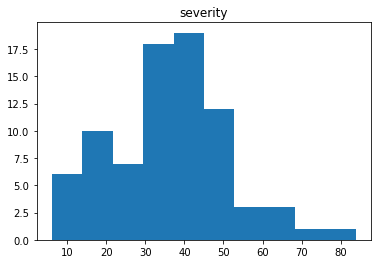

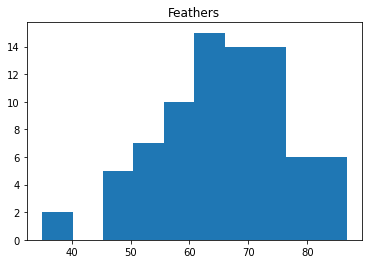

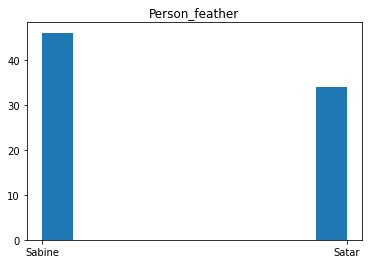

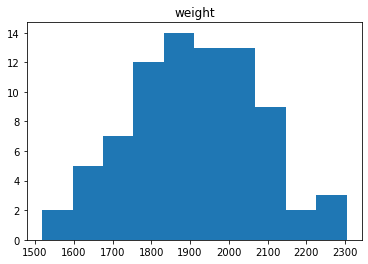

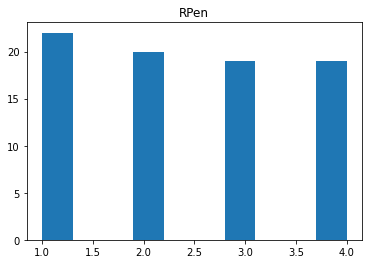

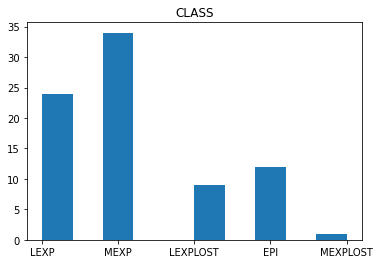

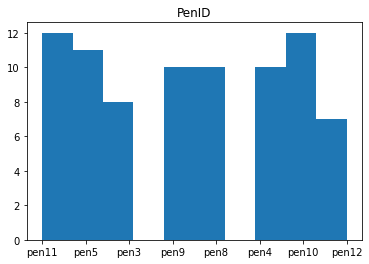

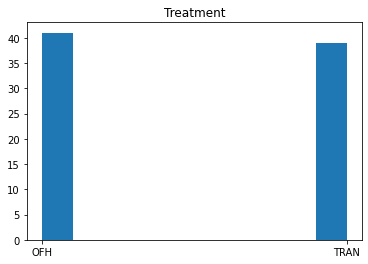

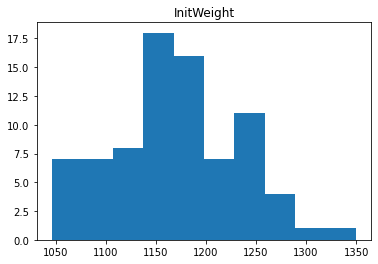

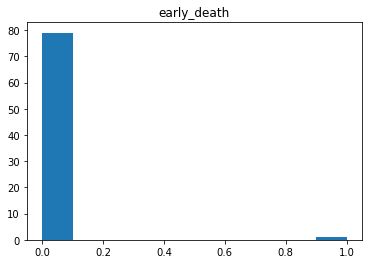

In [16]:
for x in df_MLPandHAandCV.columns:
    try:
        plt.hist(df_MLPandHAandCV[x]);
        plt.title(x)
        plt.show()
    except:
        print(x)
        pass
li_2keep = ['maxPododermatitis','severity','Feathers','Person_feather','weight',
            'mean_perc_duration_5_Zone','mean_perc_duration_4_Zone','mean_perc_duration_3_Zone','mean_perc_duration_2_Zone',
            'mean_perc_1_Zone_while_WG_open',
            'mean_vertical_travel_distance_perh','nbr_days_4zonevisited', 'nbr_days_nomvt','nbr_obs','nbr_obs_WG']

In [17]:
print(list(df_MLPandHAandCV.columns))

['HenID', 'maxPododermatitis', 'maxHasBumblefoot', 'maxhas_gap', 'nbr_HA', 'nbr_obs', 'nbr_obs_WG', 'mssd_perc_duration_5_Zone', 'mean_perc_duration_5_Zone', 'sampen_perc_duration_5_Zone', 'nbr_obs_perc_duration_5_Zone', 'mssd_perc_duration_4_Zone', 'mean_perc_duration_4_Zone', 'sampen_perc_duration_4_Zone', 'nbr_obs_perc_duration_4_Zone', 'mssd_perc_duration_3_Zone', 'mean_perc_duration_3_Zone', 'sampen_perc_duration_3_Zone', 'nbr_obs_perc_duration_3_Zone', 'mssd_perc_duration_2_Zone', 'mean_perc_duration_2_Zone', 'sampen_perc_duration_2_Zone', 'nbr_obs_perc_duration_2_Zone', 'mssd_perc_1_Zone_while_WG_open', 'mean_perc_1_Zone_while_WG_open', 'sampen_perc_1_Zone_while_WG_open', 'nbr_obs_perc_1_Zone_while_WG_open', 'mssd_vertical_travel_distance_perh', 'mean_vertical_travel_distance_perh', 'sampen_vertical_travel_distance_perh', 'nbr_obs_vertical_travel_distance_perh', 'nbr_days_4zonevisited', 'nbr_days_nomvt', 'severity', 'Feathers', 'Person_feather', 'weight', 'RPen', 'CLASS', 'PenID

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_MLPandHAandCV['early_death'].value_counts() #cant use it

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    79
1.0     1
Name: early_death, dtype: int64

In [19]:
df_MLPandHAandCV['maxhas_gap'].value_counts() # use it, buta ctually doe snot make sense: its a matter of time

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.0    40
0.0    40
Name: maxhas_gap, dtype: int64

In [20]:
df_MLPandHAandCV['maxHasBumblefoot'].value_counts() #cant use it

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    77
1     3
Name: maxHasBumblefoot, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


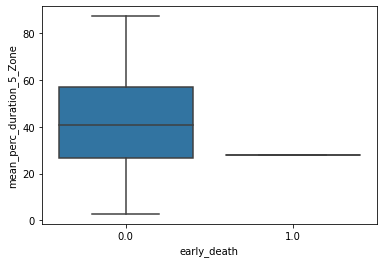

In [21]:
sns.boxplot(x='early_death',y='mean_perc_duration_5_Zone', data=df_MLPandHAandCV);

In [22]:
#show rows with at least one nan of the columns haveing nan at least one time in the df
#indeed, one bird missing.
df_MLPandHAandCV[df_MLPandHAandCV[li_2keep+li_initvar].isna().any(axis=1)][li_2keep+li_initvar]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,maxPododermatitis,severity,Feathers,Person_feather,weight,mean_perc_duration_5_Zone,mean_perc_duration_4_Zone,mean_perc_duration_3_Zone,mean_perc_duration_2_Zone,mean_perc_1_Zone_while_WG_open,...,nbr_days_nomvt,nbr_obs,nbr_obs_WG,HenID,RPen,CLASS,PenID,Treatment,InitWeight,early_death
65,100.0,30,NaN,Sabine,1626.2,61.367347,10.836735,7.510204,15.755102,12.115531,...,1,49,42,hen_78,2.0,LEXP,pen10,TRAN,1060.0,0.0


In [23]:
#save
print(df_MLPandHAandCV.shape)
df_MLPandHAandCV[~df_MLPandHAandCV['Feathers'].isnull()][li_2keep+li_initvar].to_csv(os.path.join(path_extracted_data_adap,'Adaptability_Stat.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(80, 43)


# MLP ~ short-term & long term MLPS

In [24]:
def pearsonr_ci(x, y, alpha=0.05):
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return (r, p, lo, hi)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
dico_h_tr = dict(zip(df_HA['HenID'].tolist(), df_HA['Treatment'].tolist()))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
li_DOA = [int(x) for x in  df_MVT['DOA'].unique()]
li_df = []
li_mvt4MLPs_ = ['perc_duration_5_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'vertical_travel_distance_perh']
for type_ in tqdm.tqdm(li_mvt4MLPs_):
    df_pivot = df_MVT.pivot(index='HenID', values=type_, columns='DOA').reset_index()
    for d1 in range(min(li_DOA),max(li_DOA)):
        for d2 in range(d1+1,max(li_DOA)+1):
            if (d2 in li_DOA)&(d1 in li_DOA):
                df_ = df_pivot.copy()
                df_ = df_.dropna(subset=[d1,d2])
                if df_.shape[0]>80:
                    df_['treatment'] = df_['HenID'].map(lambda x: dico_h_tr.get(x,np.nan))
                    #print(df_.shape)
                    #alltogether
                    coeff, p_val = pearsonr(df_[d1].tolist(), df_[d2].tolist())
                    coeff_np, p_val_np = spearmanr(df_[d1].tolist(), df_[d2].tolist())
                    r, p, lo, hi = pearsonr_ci(np.array(df_[d1].tolist()), np.array(df_[d2].tolist()))
                    li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df_.shape[0], 'coeff_np':coeff_np, 'p_val_np':p_val_np,
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':'alltogether'})   
                    for tr,df__ in df_.groupby(['treatment']):
                        coeff, p_val = pearsonr(df__[d1].tolist(), df__[d2].tolist())
                        coeff_np, p_val_np = spearmanr(df__[d1].tolist(), df__[d2].tolist())
                        r, p, lo, hi = pearsonr_ci(np.array(df__[d1].tolist()), np.array(df__[d2].tolist()))
                        li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df__.shape[0],'coeff_np':coeff_np, 'p_val_np':p_val_np,
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':tr})   
                else:
                    #print('--------------- not enough data')
                    #print(df_.shape)
                    #print(d1,d2)
                    pass
df_corrddx = pd.DataFrame(li_df)
df_corrddx['significant'] = df_corrddx['p_val'].map(lambda x: x<0.05)
print(df_corrddx.shape)
display(df_corrddx.head(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.93s/it]

(13512, 14)


,coeff,p_val,d1,d2,diff,type_,nbr_obs,coeff_np,p_val_np,L,H,verif,treatment,significant
0,0.629425,1.051625e-15,119,120,1,perc_duration_5_Zone,130,0.637611,3.426772e-16,0.512817,0.723229,"(0.6294250150096447, 1.051624585787605e-15)",alltogether,True
1,0.595776,1.645364e-07,119,120,1,perc_duration_5_Zone,65,0.616877,4.451843e-08,0.411701,0.733143,"(0.5957759760201989, 1.6453641008718078e-07)",OFH,True
2,0.704497,8.248762e-11,119,120,1,perc_duration_5_Zone,64,0.695439,1.804677e-10,0.554755,0.810031,"(0.7044966445891545, 8.248761556360375e-11)",TRAN,True
3,0.528686,1.009897e-10,119,121,2,perc_duration_5_Zone,130,0.533886,6.113550e-11,0.392204,0.642394,"(0.5286864011436521, 1.0098973988873229e-10)",alltogether,True
4,0.450445,1.664713e-04,119,121,2,perc_duration_5_Zone,65,0.468576,8.263982e-05,0.232038,0.625612,"(0.4504451125637592, 0.00016647133998378867)",OFH,True


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


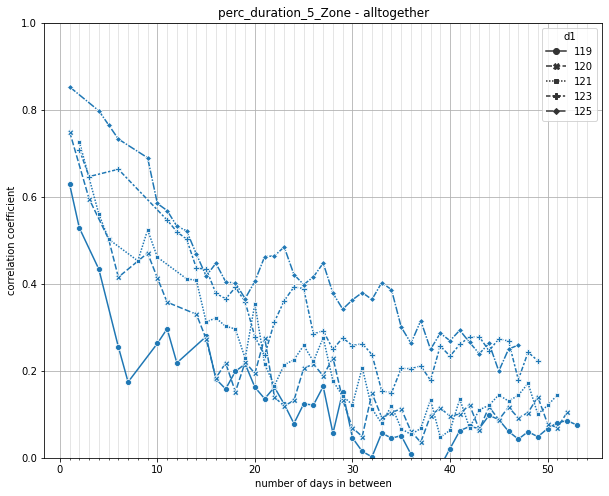

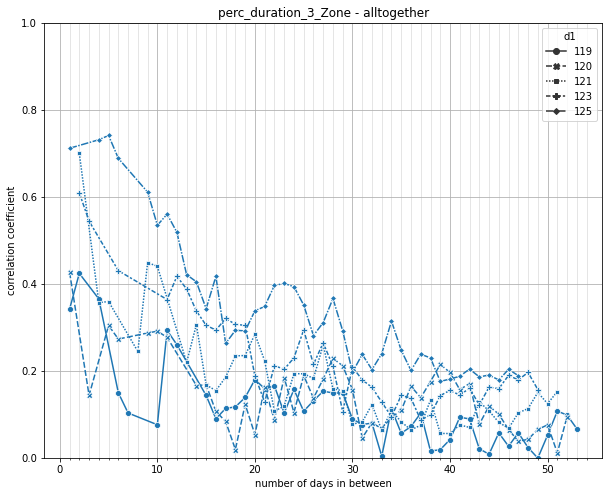

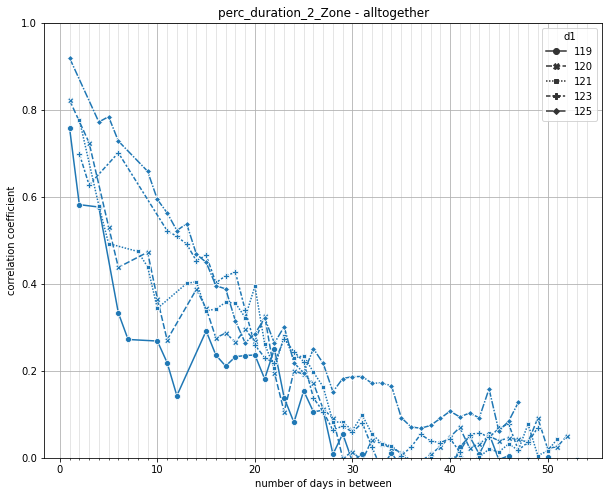

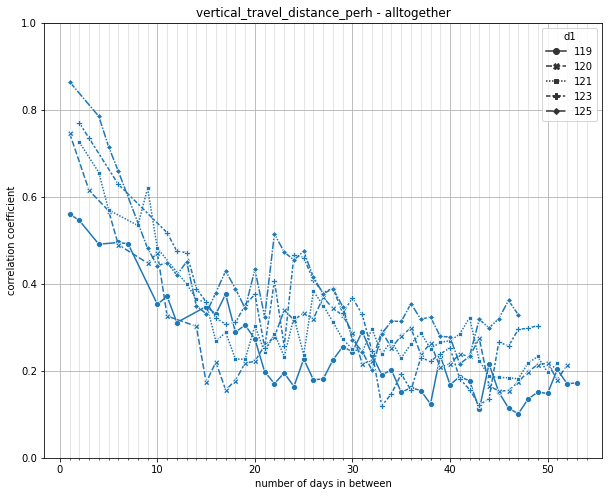

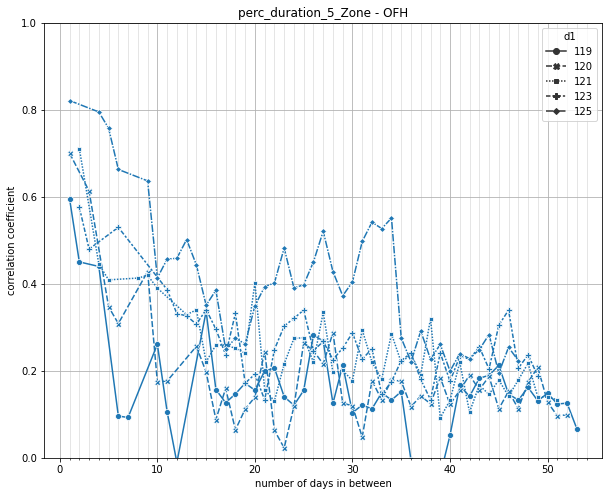

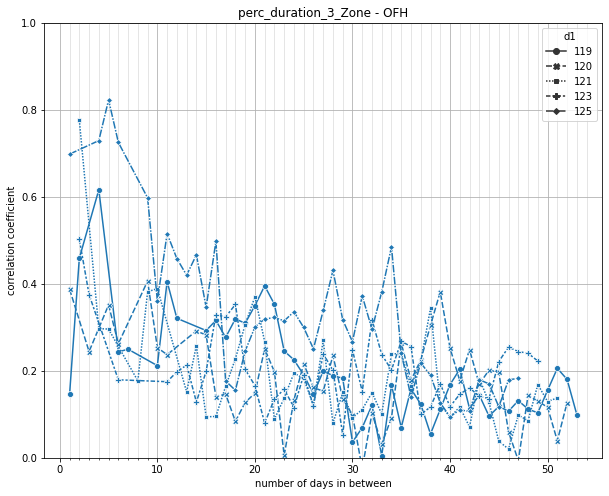

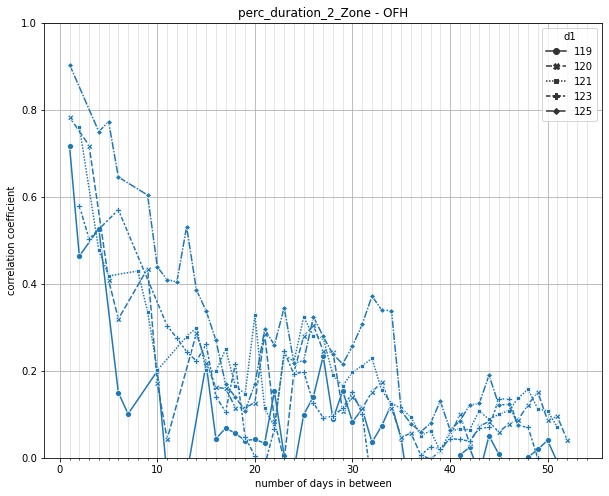

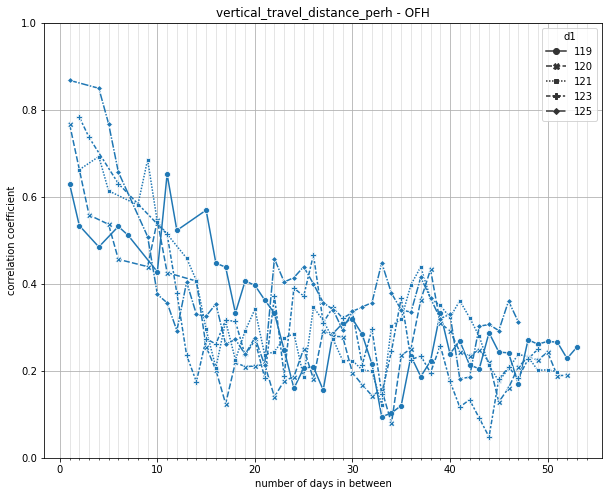

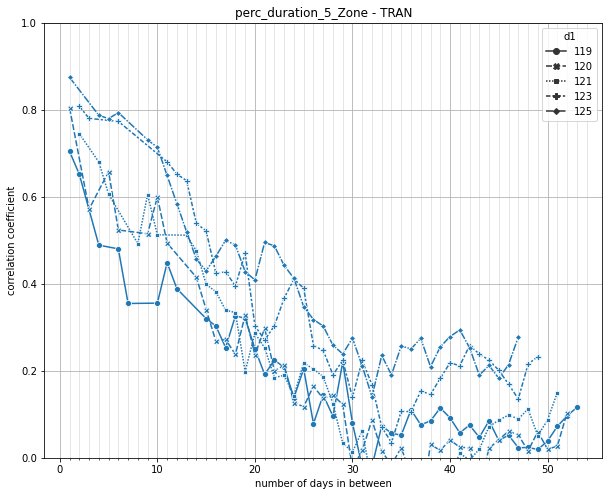

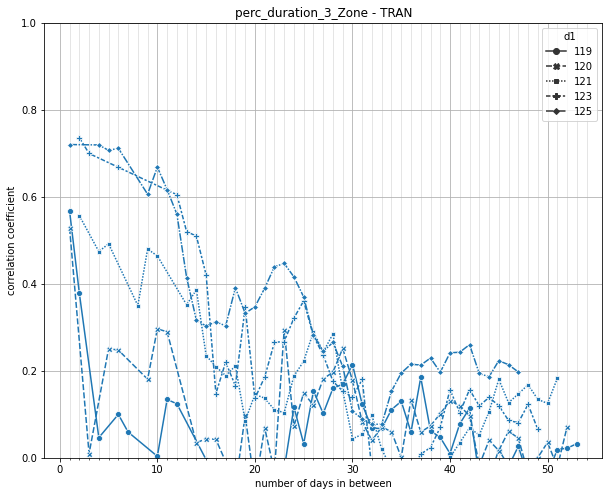

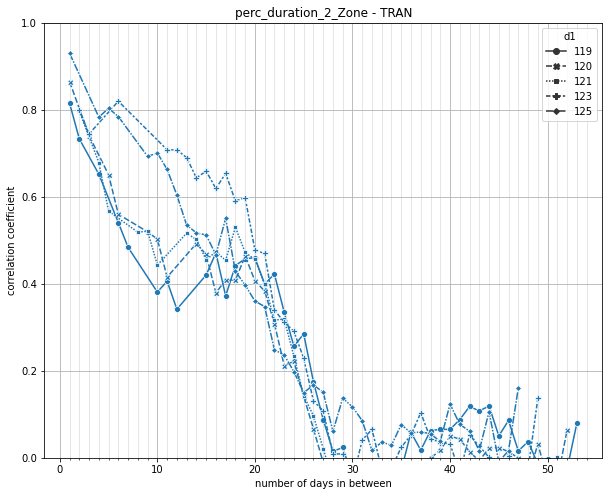

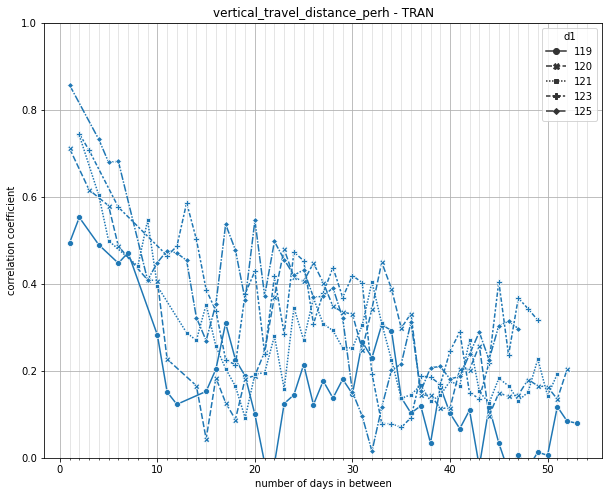

In [27]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data_adap, 'Correlation_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


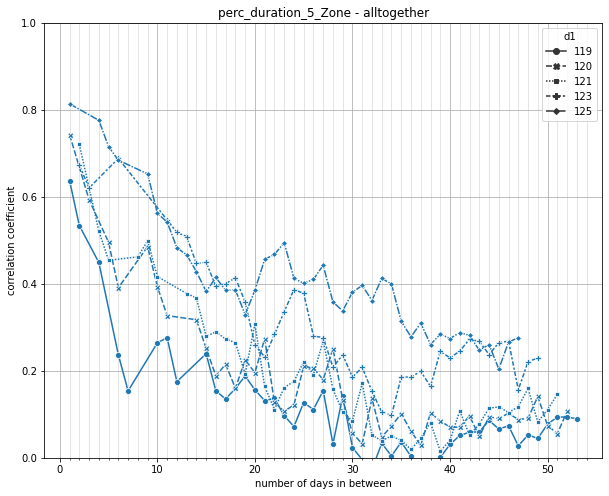

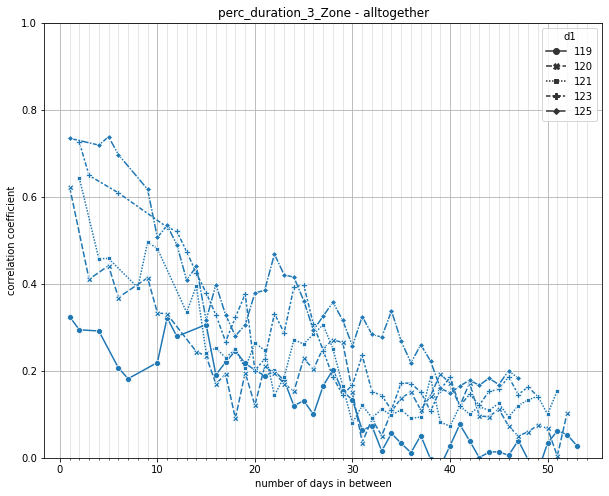

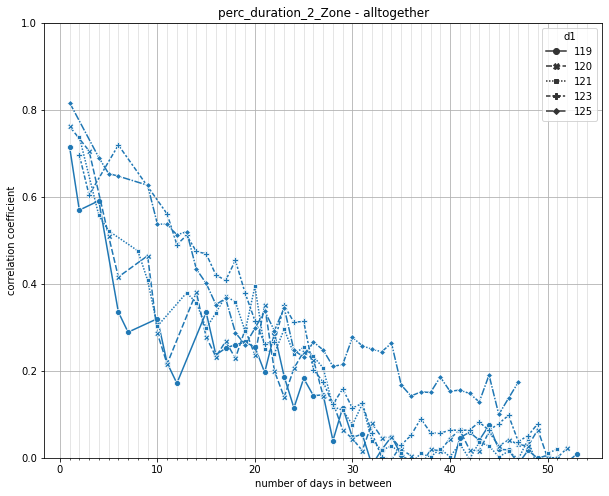

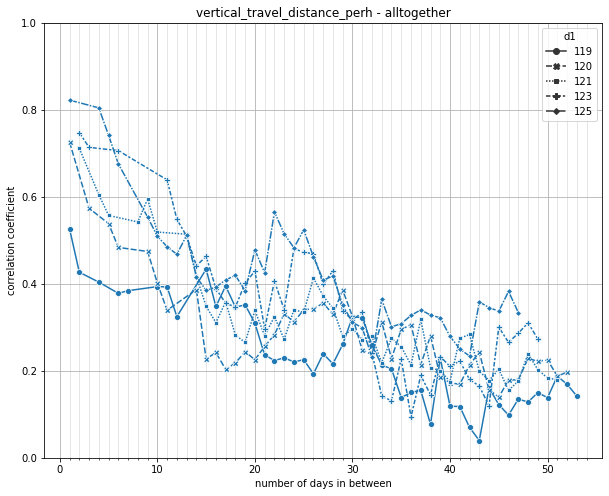

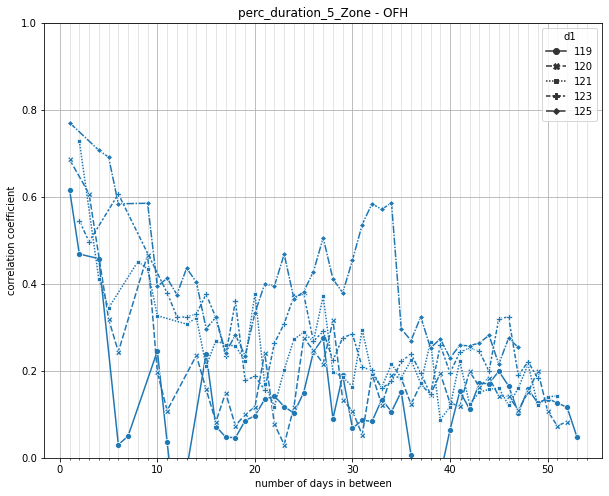

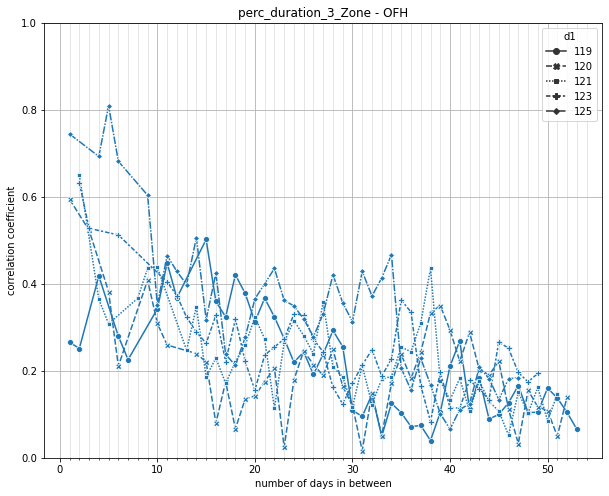

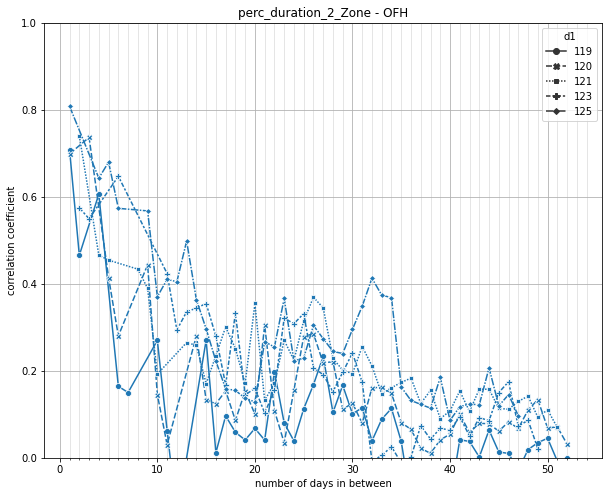

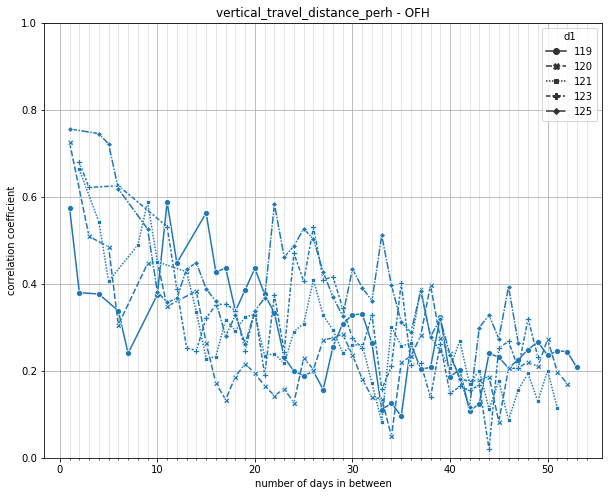

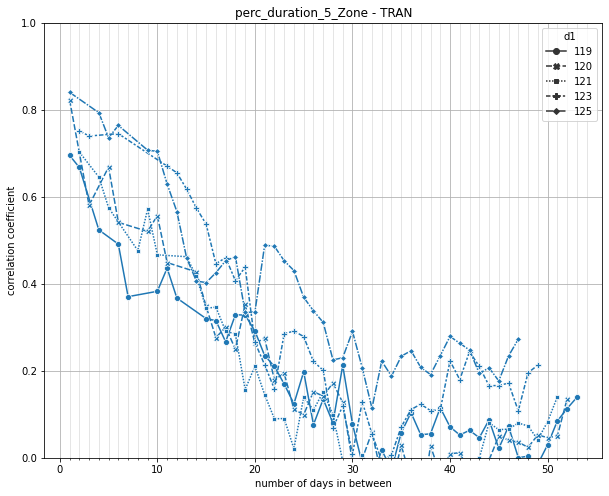

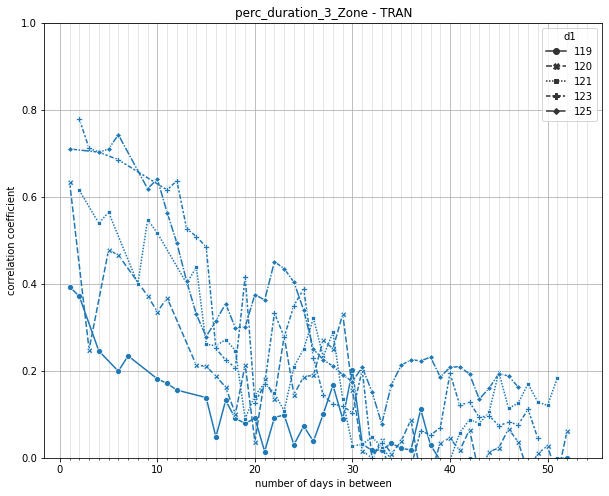

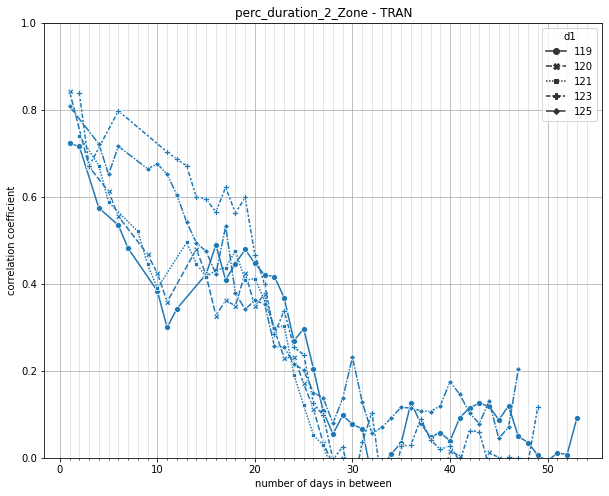

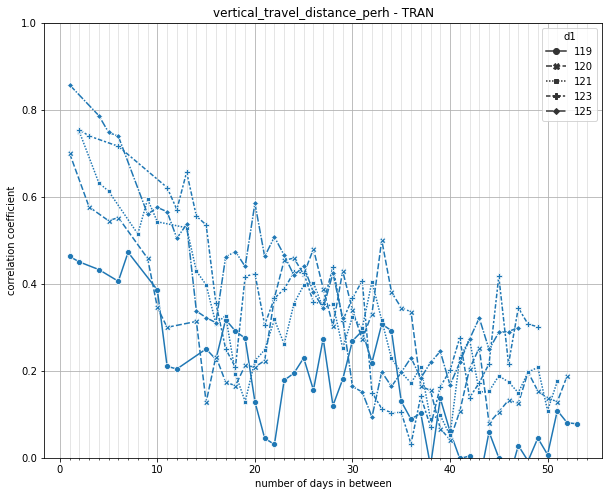

In [28]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff_np', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data_adap, 'CorrelationNP_Predictibility_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


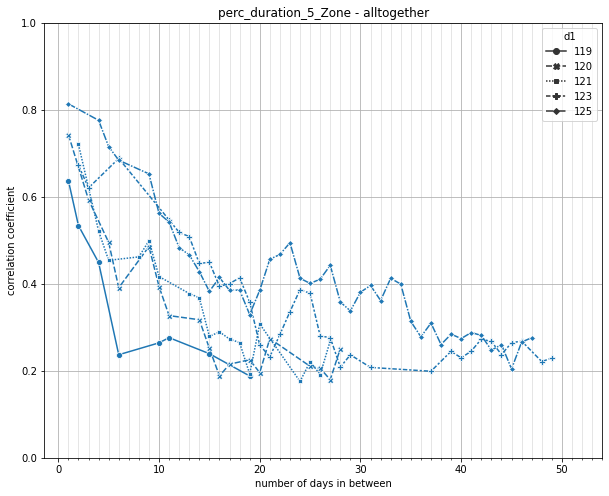

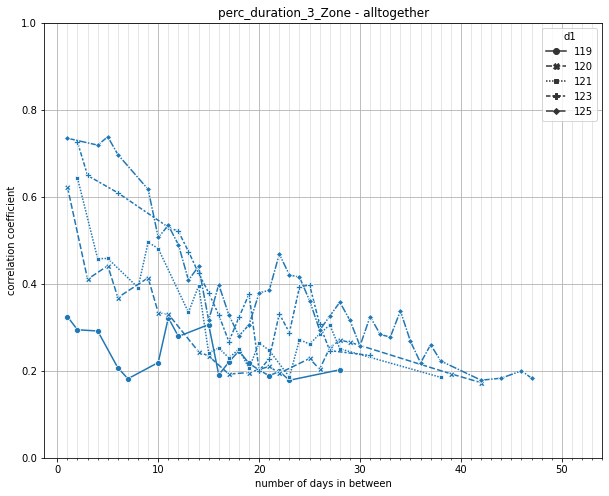

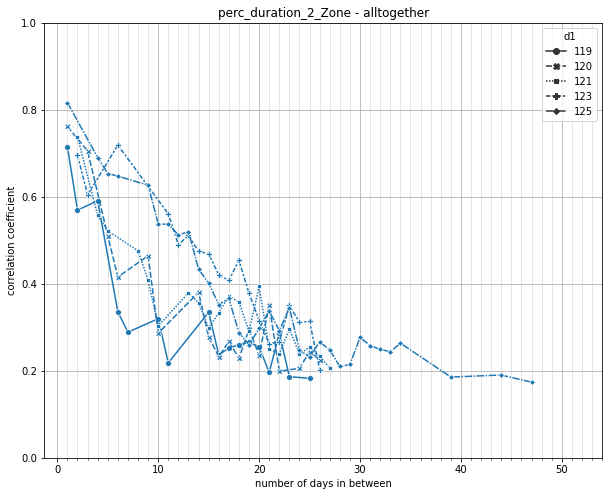

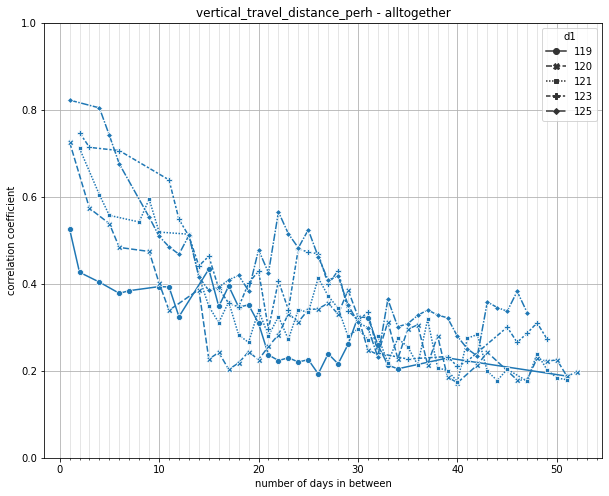

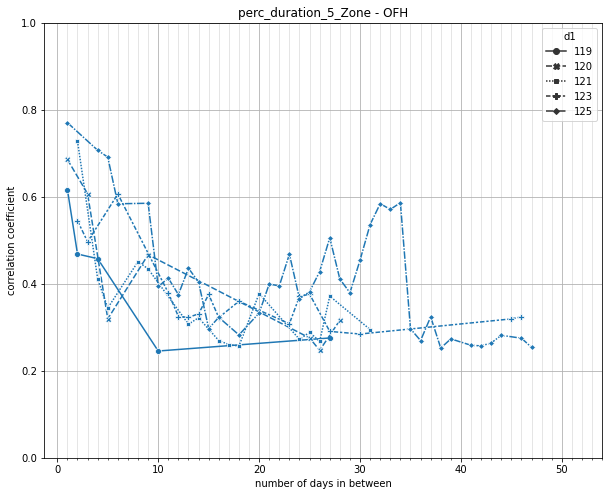

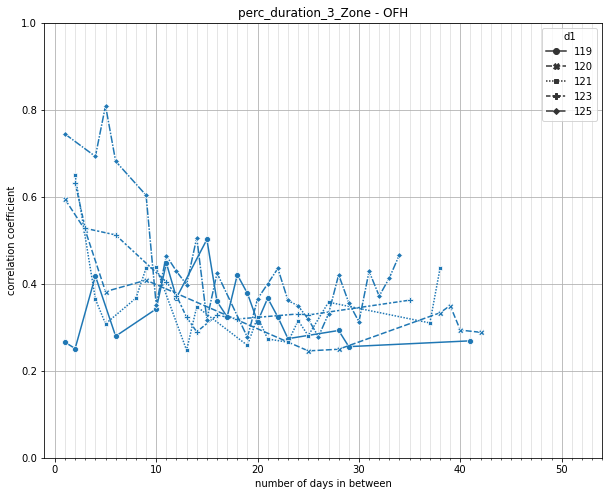

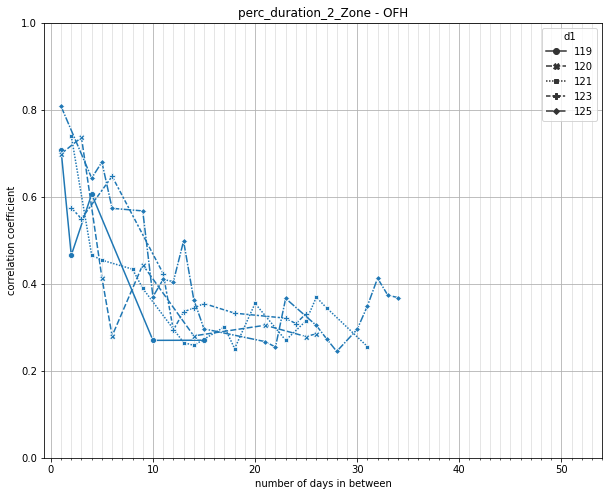

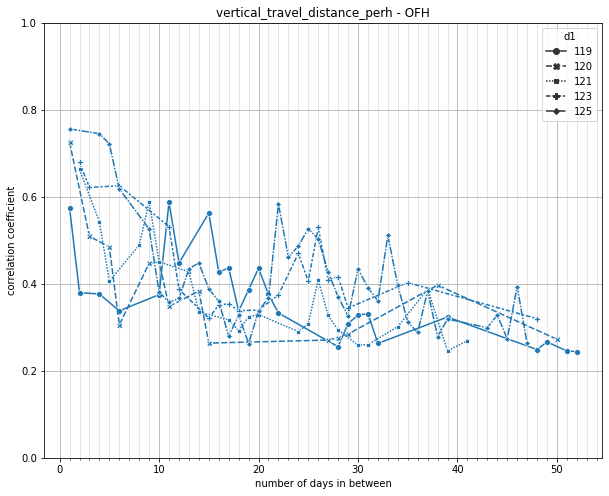

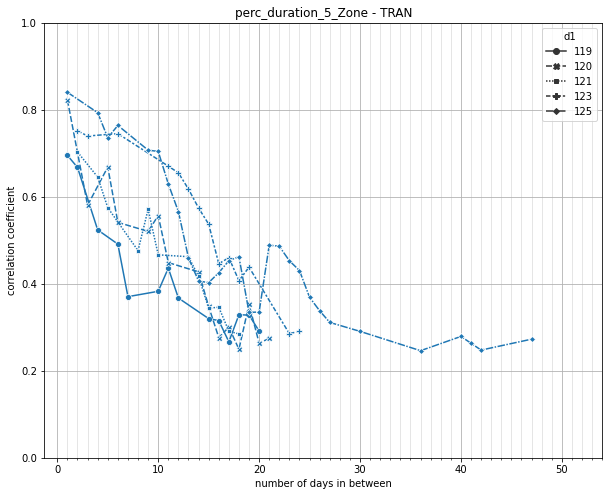

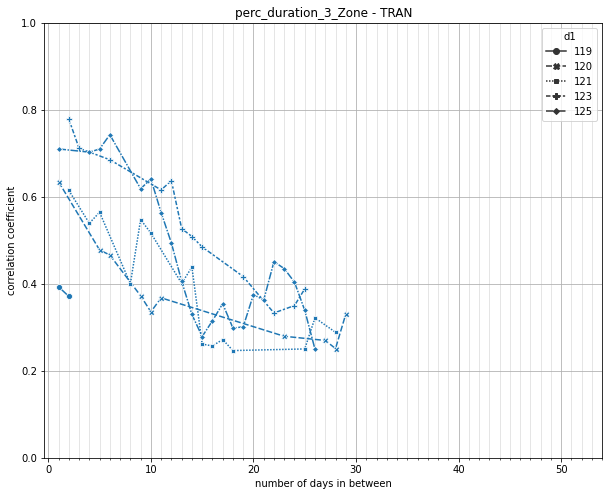

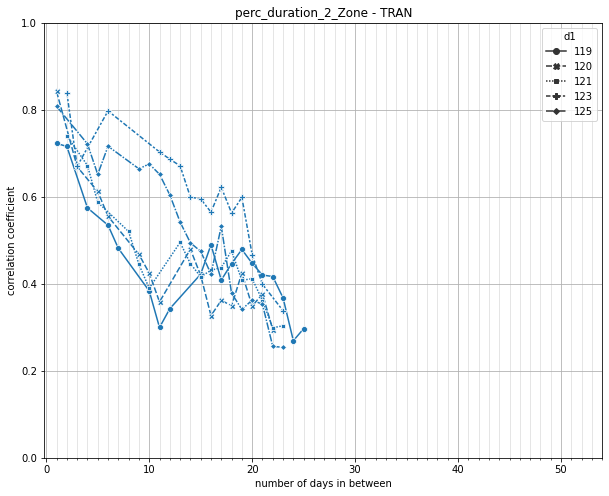

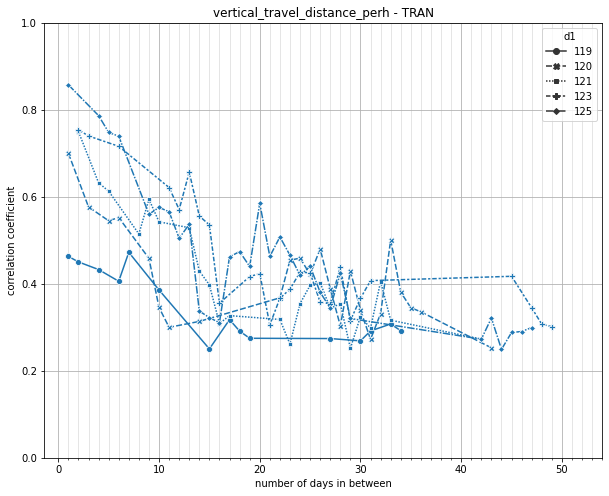

In [29]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff_np', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)&\
                                                                    (df_corrddx['p_val_np']<0.05)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data_adap, 'CorrelationNP_SIGN_Predictibility_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

In [30]:
df_test = df_corrddx[(df_corrddx['d1']==119)&(df_corrddx['type_']=='vertical_travel_distance_perh')&\
                     (df_corrddx['treatment']=='alltogether')&(df_corrddx['p_val_np']<0.05)]
df_test

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coeff,p_val,d1,d2,diff,type_,nbr_obs,coeff_np,p_val_np,L,H,verif,treatment,significant
10134,0.560716,3.982679e-12,119,120,1,vertical_travel_distance_perh,130,0.526342,1.262909e-10,0.430050,0.668372,"(0.5607158958913306, 3.982678899599684e-12)",alltogether,True
10137,0.545813,1.870422e-11,119,121,2,vertical_travel_distance_perh,130,0.426641,4.158744e-07,0.412384,0.656318,"(0.5458134438946677, 1.870421808321281e-11)",alltogether,True
10140,0.491144,2.824779e-07,119,123,4,vertical_travel_distance_perh,98,0.403992,3.702915e-05,0.324330,0.628332,"(0.4911436506048701, 2.82477903832446e-07)",alltogether,True
10143,0.495152,2.114220e-09,119,125,6,vertical_travel_distance_perh,130,0.378219,9.136171e-06,0.353068,0.614912,"(0.49515188077625466, 2.1142199584106936e-09)",alltogether,True
10146,0.492158,2.730582e-09,119,126,7,vertical_travel_distance_perh,130,0.384301,6.362482e-06,0.349598,0.612444,"(0.492158302557955, 2.7305818644449898e-09)",alltogether,True
10149,0.353042,3.790652e-05,119,129,10,vertical_travel_distance_perh,130,0.393685,3.588731e-06,0.192561,0.495129,"(0.3530415633189109, 3.7906524281942614e-05)",alltogether,True
10152,0.371211,5.504574e-04,119,130,11,vertical_travel_distance_perh,83,0.392874,2.389116e-04,0.169057,0.543393,"(0.3712105717199797, 0.00055045736980575)",alltogether,True
10155,0.311025,4.210461e-03,119,131,12,vertical_travel_distance_perh,83,0.324601,2.754153e-03,0.102191,0.493601,"(0.31102508150835556, 0.004210461261335566)",alltogether,True
10158,0.347847,5.363236e-05,119,134,15,vertical_travel_distance_perh,129,0.433760,2.819810e-07,0.186187,0.491169,"(0.3478466931323178, 5.363236147753797e-05)",alltogether,True
10161,0.330736,1.290892e-04,119,135,16,vertical_travel_distance_perh,129,0.347976,5.326715e-05,0.167455,0.476358,"(0.3307363626157915, 0.00012908916980254164)",alltogether,True


df_res = pd.read_csv(os.path.join(path_extracted_data_adap,'df_MVT_repeatibilityWIB.csv'), sep=',') 
df_res

df_res['li_var'] = df_res['li_var'].map(lambda x: x.replace('perc_duration_',
                                                            '% time spent in').replace('2_Zone',
                                                            'litter').replace('3_Zone','lower perch').replace('4_Zone',
                                                    'nestbox').replace('5_Zone','top floor'))
df_res = df_res.rename(columns={'li_var':'individual daily variables'})

df_res.to_csv(os.path.join(path_adapt,'df_MVT_repeatibilityWIB_p.csv'), index=False, sep=';')